# Shifting Bottleneck Heuristics
### Author: Jose R Vasquez Perez

In [273]:
# import modules needed for this

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

First, I create table with information regarding the number of jobs (ex. Assembly, Slitting, Packing), the order of machines/stations that each job has to go through, and the processing time it takes for a machine/station to complete a step in a specific job.

In [278]:
# Creating table
machines = ['m1', 'm2', 'm3']
jobs = pd.DataFrame({}, columns=machines + ['order'])
jobs.index.name = 'jobs'

# Entering job names, machines, and processing times into table 

jobs.loc['Assembly'] = {'m1':7,
                        'm2':10,
                        'm3':8,
                        'order': ['m1', 'm3', 'm2']}
jobs.loc['Slitting'] = {'m1':4,
                        'm2':6,
                        'm3':12,
                        'order': ['m2', 'm1', 'm3']}
jobs.loc['Packing'] = {'m1':8,
                        'm2':8,
                        'm3':7,
                        'order': ['m1', 'm2', 'm3']}
jobs

,m1,m2,m3,order
jobs,,,,
Assembly,7,10,8,"[m1, m3, m2]"
Slitting,4,6,12,"[m2, m1, m3]"
Packing,8,8,7,"[m1, m2, m3]"


Next, I calculated the total processing time for each individual machine/station

(ex. Machine 1 will take 7 minutes processing Assembly, 4 minutes processing slitting, and 8 minutes processing Packing)

In [455]:
job_names = list(jobs.index)

# create table to save results
m_total = pd.DataFrame({}, columns=['total'])
m_total.index.name = 'm #'

for m in machines:
    m_total.loc[m] = {'total':0}
    for i in job_names: # find summation for machine m
        m_total['total'][m] = jobs[m][i] + m_total['total'][m]

# order by max to min table
m_total = m_total.sort_values(by= 'total', ascending=False)
m_total
        

,total
m #,
m3,27
m2,24
m1,19


Afterwards, I calculated the different combinations where each job will be the first in line (only need 1 of each)

A combination is a column value shown on the table below.

(Ex. combination 1 = column 0 ie 'Assembly' 'Slitting' 'Packing')

In [464]:
# get column and row names into list (machine list and job names)
machines = list(m_total.index)
job_names = list(jobs.index)

# combination list table creation
def node_order(job_name_order, start_from_index):
    iteration = pd.DataFrame({})
    for i in range(start_from_index, len(job_name_order)):
        popped = job_name_order[:]
        start = popped.pop(i)
        popped.insert(0, start)
        iteration[i] = popped
    return(iteration)

# create combinations for this iteration
iteration_1 = node_order(job_names, 0)
iteration_1

,0,1,2
0,Assembly,Slitting,Packing
1,Slitting,Assembly,Assembly
2,Packing,Packing,Slitting


Afterwards, I decided to show the visual representation of the first round of combinations (nodes)

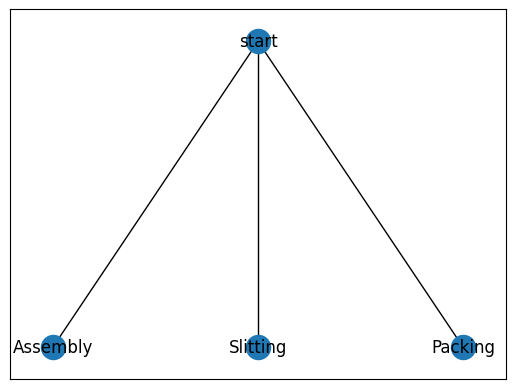

In [465]:
node = nx.Graph()
node.add_nodes_from(['start', iteration_1[0][0], iteration_1[0][1], iteration_1[0][2]])
layout = {}
node.add_edges_from([('start', iteration_1[0][0]), ('start', iteration_1[0][1]), ('start', iteration_1[0][2])])
layout = {}
layout['start'] = [0, 10]
layout[iteration_1[0][0]] = [-3, 5]
layout[iteration_1[0][1]] = [0, 5]
layout[iteration_1[0][2]] = [3, 5]
nx.draw_networkx(node, pos=layout)
plt.show()


Next, I created a function that creates table with the following information:

Processing Time (Pj) - time it takes for machine to process job

Release (Rj) - time at which machine will be available

Due Date (dd) - time at which job should be completed

Completion Time (Cj) - time at which job will be completed

Tardiness (t) - difference between time completed minus due date

In [474]:
def create_table_data(col_names, mach_num, main_table= jobs):
    table_n = pd.DataFrame({}, columns= col_names)
    for i in col_names:
        # --------------------------------------------------
        # release j
        order = jobs['order'][i]
        current = order.index(mach_num)
        release = 0
        for j in range(0, current):
            release = release + jobs[order[j]][i]
        # --------------------------------------------------
        # due date
        dd = m_total['total'][mach_num]
        for k in range(len(order)-1, -1, -1):
            if k == current:
                break
            else:
                m = order[k]
                dd = dd - jobs[m][i]
        # ---------------------------------------------------
        # Create table
        table_n[i] = {
                    'Processing Time (Pj)': jobs[mach_num][i], 
                    'Release (Rj)':release, 
                    'due date (dd)':dd, 
                    'completion time (Cj)': 0, 
                    'tardiness (t)': 0}

    # -------------------------------------------------------
    # Completion Time
    Cj = 0
    for i in col_names:
        if Cj < table_n[i][1]:
            Cj = Cj + table_n[i][1]
        Cj = Cj + table_n[i][0]
        table_n[i]['completion time (Cj)'] = Cj
        # ---------------------------------------------------
        # Tardiness
        if table_n[i]['due date (dd)'] < table_n[i]['completion time (Cj)']:
            tardiness = table_n[i]['completion time (Cj)'] - table_n[i]['due date (dd)']
            table_n[i]['tardiness (t)'] = tardiness

    return table_n

m_index = list(m_total.index)
table_data = ['']*(len(iteration_1.columns))
for i in iteration_1.columns:
    table_data[i] = create_table_data(col_names = iteration_1[i], mach_num = m_index[0])


Below I created tables to visually show the data.

Table 1 represents combination 1, 
Table 2 represents combination 2, 
etc.

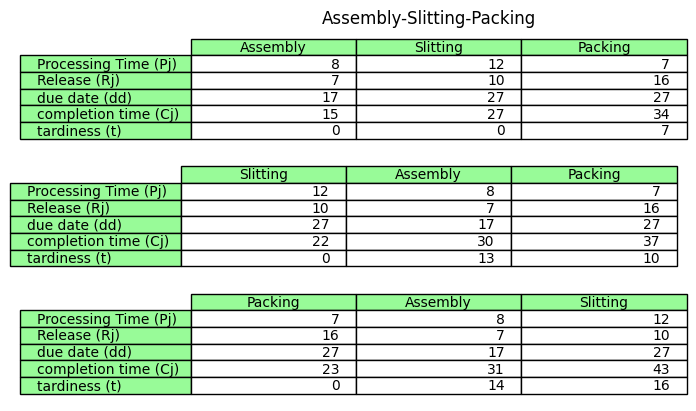

In [488]:
ax = plt
ax.axis('off')
ax.axis('tight')
ax.title('Assembly-Slitting-Packing')
table2 = ['']*3
table2[0] = ax.table(
                cellText=table_data[0].values, 
                colLabels=table_data[0].columns,
                rowLabels=table_data[0].index ,
                loc='upper left',
                rowColours =["palegreen"] * 10,
                colColours =["palegreen"] * 10)
table2[1] = ax.table(
                cellText=table_data[1].values, 
                colLabels=table_data[1].columns,
                rowLabels=table_data[1].index ,
                loc='center',
                rowColours =["palegreen"] * 10,
                colColours =["palegreen"] * 10)
table2[2] = ax.table(
                cellText=table_data[2].values, 
                colLabels=table_data[2].columns,
                rowLabels=table_data[2].index ,
                loc='lower left',
                rowColours =["palegreen"] * 10,
                colColours =["palegreen"] * 10)
ax.show()

